In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import ast


from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
from tqdm import tqdm
sns.set_theme()
from collections import defaultdict


### Read & Display CSV Files

In [2]:
solar_data = pd.read_csv('solar_data.csv')
census_data = pd.read_csv('census_data.csv')


In [3]:
print('HEAD', census_data.head())
print('INFO', census_data.info())
print('DESCRIPTION', census_data.describe())
path_name = './Figure/'
png_path_name = './Figure/png/'

HEAD       Block  Median Income  Employment Rate  Total Population  Poverty  \
0  812103-1          52154              565              1104       85   
1  811800-3          43850              548              1020       70   
2  812001-3          22670              340               807       79   
3  811900-1         110583              719              1179      120   
4  812101-1          70625             1154              2084      414   

   Total Housing Units  Renter-Occupied Units  Electric Heating Units  \
0                  435                    189                     122   
1                  463                    329                     153   
2                  483                    394                     188   
3                  425                    106                      42   
4                  874                    230                     129   

   Gas Heating Units  Oil Heating Units  ...  2010to2013  2000to2009  \
0                136                154

In [4]:
census_data.columns

Index(['Block', 'Median Income', 'Employment Rate', 'Total Population',
       'Poverty', 'Total Housing Units', 'Renter-Occupied Units',
       'Electric Heating Units', 'Gas Heating Units', 'Oil Heating Units',
       'Median Year Structure Built', 'after2014', '2010to2013', '2000to2009',
       '1990to1999', '1980to1989', '1970to1979', '1960to1969', '1950to1959',
       '1940to1949', 'pre1939', 'house_ids'],
      dtype='object')

### Plot to see the Number of Housing Units by Construction Year Category
Most of the houses were built in <1939, followed by 1990

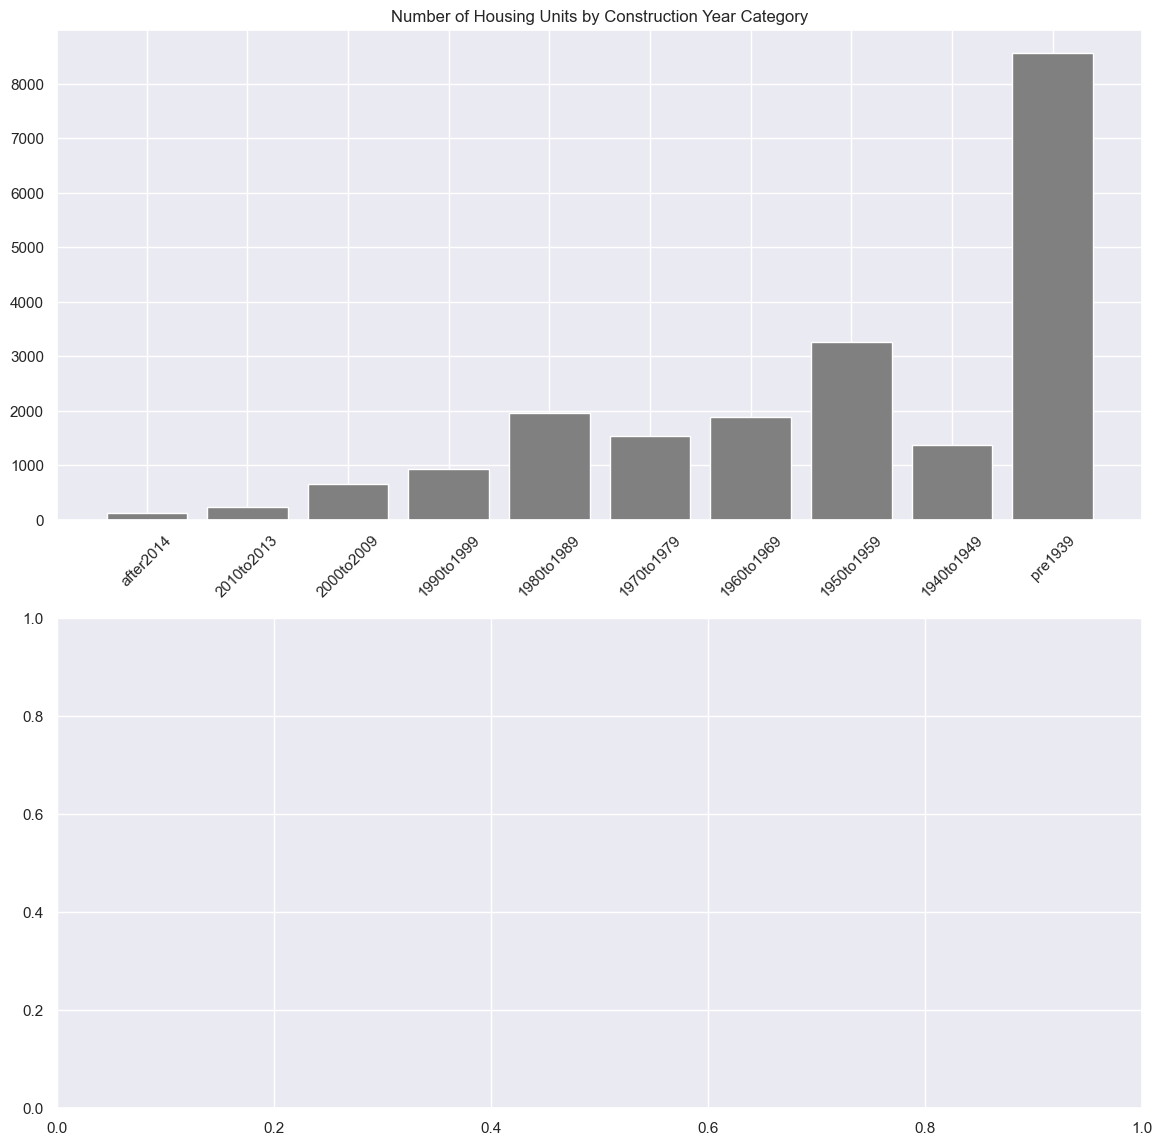

In [5]:
# Set up the figure for both plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))


# Data preparation for line chart
years_labels = ['after2014', '2010to2013', '2000to2009', '1990to1999', '1980to1989', 
                '1970to1979', '1960to1969', '1950to1959', '1940to1949', 'pre1939']
years_values = [census_data[label].sum() for label in years_labels]

# Line chart of housing units by construction year categories
ax1.bar(years_labels, years_values, color='grey')
ax1.set_title('Number of Housing Units by Construction Year Category')
ax1.grid(True)

# Improve the x-ticks for better visualization
ax1.set_xticks(years_labels)
ax1.set_xticklabels(years_labels, rotation=45)

# Show plot
plt.show()

### Display the Total Housing Units vs. Renter-Occupied Units, Percent of the Renter-occupied Units 

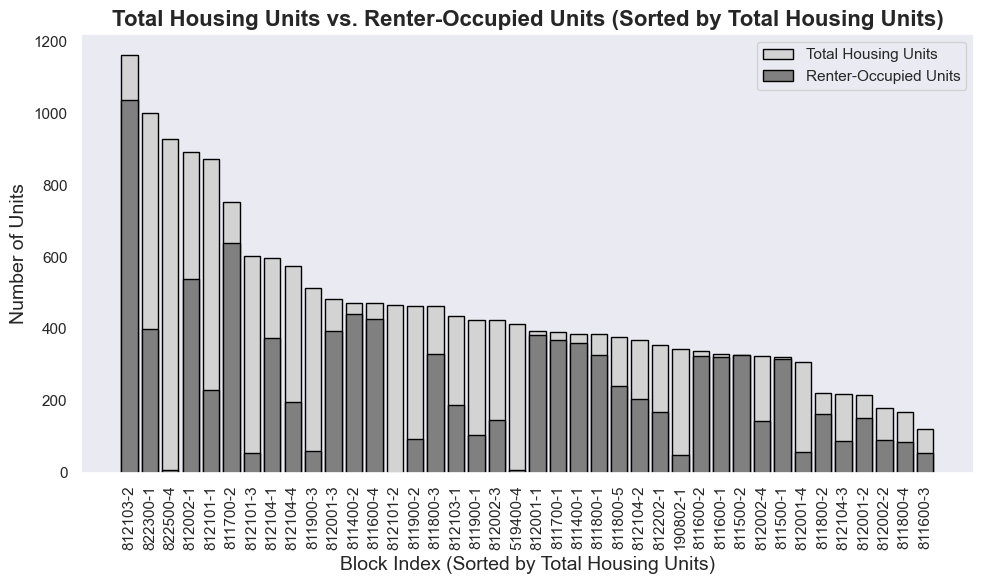

Percentage of Renter-Occupied Units: 53.525312010373334
Average Renter-Occupied Units: 247.675
Median Renter-Occupied Units: 201.5
Interquartile Range (IQR) of Renter-Occupied Units: 271.5


In [6]:
# Define the columns for the bar chart: 'Total Housing Units' and 'Renter-Occupied Units'
total_housing_units = census_data['Total Housing Units']
renter_occupied_units = census_data['Renter-Occupied Units']

# Sorting by total housing units
sorted_indices = total_housing_units.argsort()[::-1]
sorted_total_housing_units = total_housing_units[sorted_indices]
sorted_renter_occupied_units = renter_occupied_units[sorted_indices]

# Set style for no gridlines and grey-white color palette
plt.rcParams['axes.grid'] = False
colors = {'total': 'lightgrey', 'renter': 'grey'}
edge_color = 'black'

# Plotting Bar Chart Sorted by Number of Units
plt.figure(figsize=(10, 6))
plt.bar(range(len(census_data)), sorted_total_housing_units, color=colors['total'], edgecolor=edge_color, label='Total Housing Units')
plt.bar(range(len(census_data)), sorted_renter_occupied_units, color=colors['renter'], edgecolor=edge_color, label='Renter-Occupied Units')
plt.xlabel('Block Index (Sorted by Total Housing Units)', fontdict={'fontsize': 14})
plt.ylabel('Number of Units', fontdict={'fontsize': 14})
plt.title('Total Housing Units vs. Renter-Occupied Units (Sorted by Total Housing Units)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend()
plt.xticks(range(len(census_data)), census_data['Block'][sorted_indices], rotation=90)
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(path_name + 'housing_units_bar_chart.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'housing_units_bar_chart.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

# Calculation for Percentage of Renter-Occupied Units
percentage_renter_occupied = 100 * renter_occupied_units.sum() / total_housing_units.sum()
print("Percentage of Renter-Occupied Units:", percentage_renter_occupied)

# Calculation for Average Renter-Occupied Units, Median, and IQR
average_renter_occupied_units = renter_occupied_units.mean()
median_renter_occupied_units = renter_occupied_units.median()
Q1 = renter_occupied_units.quantile(0.25)
Q3 = renter_occupied_units.quantile(0.75)
IQR = Q3 - Q1

print("Average Renter-Occupied Units:", average_renter_occupied_units)
print("Median Renter-Occupied Units:", median_renter_occupied_units)
print("Interquartile Range (IQR) of Renter-Occupied Units:", IQR)

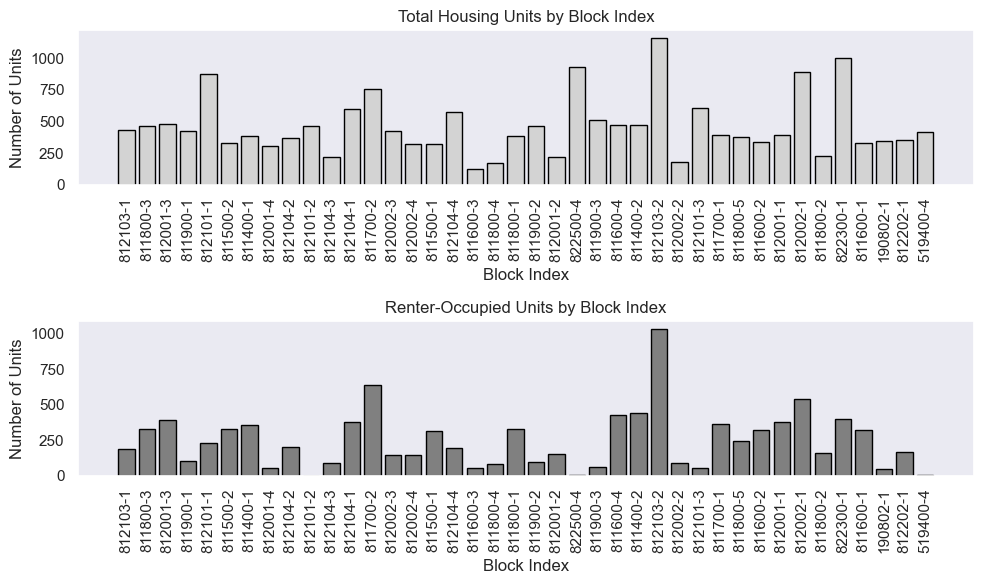

In [7]:
# Plotting Two Bar Charts for Total Units and Total Rented Units
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(range(len(census_data)), total_housing_units, color=colors['total'], edgecolor=edge_color, label='Total Housing Units')
plt.xlabel('Block Index')
plt.ylabel('Number of Units')
plt.title('Total Housing Units by Block Index')
plt.xticks(range(len(census_data)), census_data['Block'], rotation=90)

plt.subplot(2, 1, 2)
plt.bar(range(len(census_data)), renter_occupied_units, color=colors['renter'], edgecolor=edge_color, label='Renter-Occupied Units')
plt.xlabel('Block Index')
plt.ylabel('Number of Units')
plt.title('Renter-Occupied Units by Block Index')
plt.xticks(range(len(census_data)), census_data['Block'], rotation=90)
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(path_name + 'total_renter_units_bar_chart.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'total_renter_units_bar_chart.png', format='png', bbox_inches='tight')

plt.show()


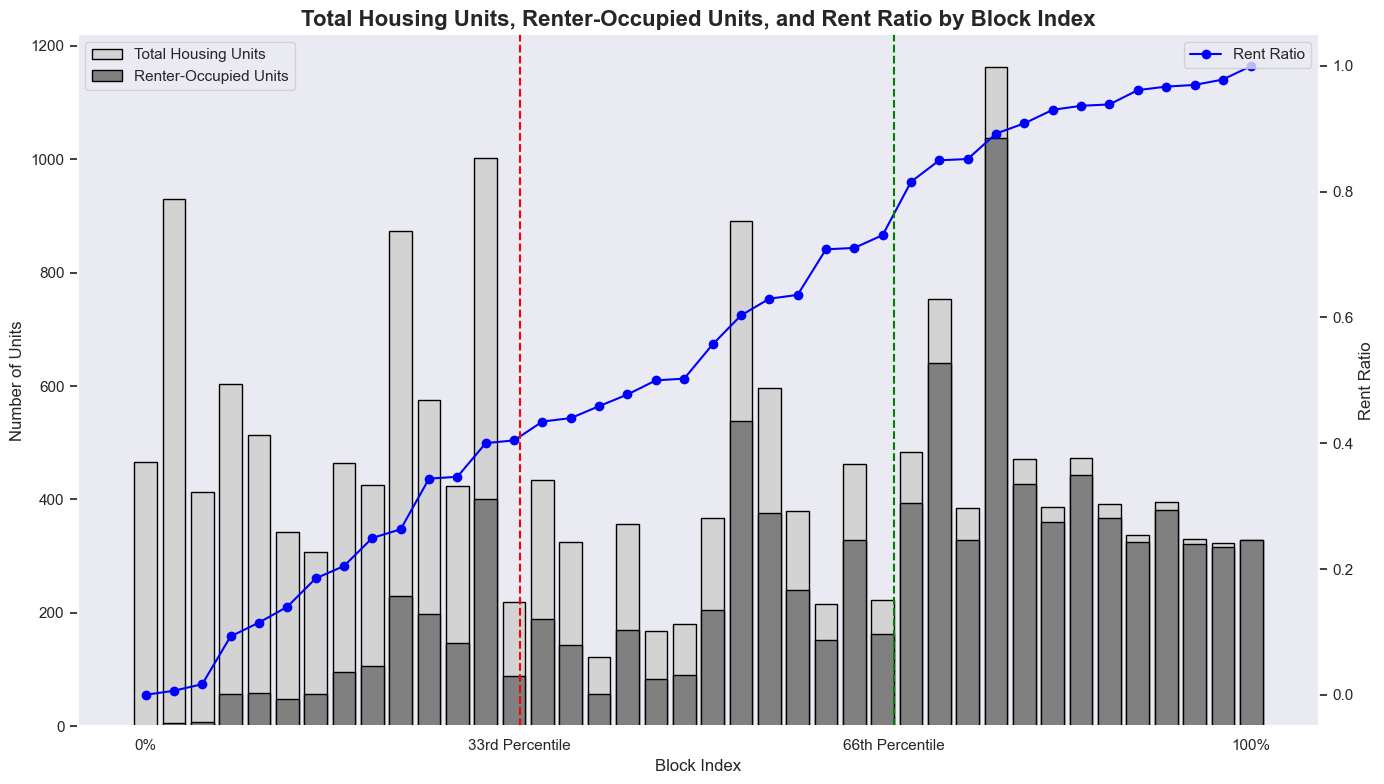

In [8]:
# Calculate rent-ratio
census_data['Rent Ratio'] = census_data['Renter-Occupied Units'] / census_data['Total Housing Units']

# Sort data by rent-ratio
census_data_sorted = census_data.sort_values(by='Rent Ratio').reset_index(drop=True)

# Determine key percentiles
low_rent_threshold = np.percentile(census_data_sorted['Rent Ratio'], 33)
median_rent_threshold = np.percentile(census_data_sorted['Rent Ratio'], 50)
high_rent_threshold = np.percentile(census_data_sorted['Rent Ratio'], 66)

# Plot stacked bar chart with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for total housing units and renter-occupied units with borders
bars1 = ax1.bar(census_data_sorted.index, census_data_sorted['Total Housing Units'], color='lightgrey', edgecolor='black', label='Total Housing Units')
bars2 = ax1.bar(census_data_sorted.index, census_data_sorted['Renter-Occupied Units'], color='grey', edgecolor='black', label='Renter-Occupied Units')

ax1.set_xlabel('Block Index')
ax1.set_ylabel('Number of Units')
ax1.legend(loc='upper left')

# Add second y-axis for rent-ratio
ax2 = ax1.twinx()
ax2.plot(census_data_sorted.index, census_data_sorted['Rent Ratio'], color='blue', marker='o', linestyle='-', label='Rent Ratio')
ax2.set_ylabel('Rent Ratio')
ax2.legend(loc='upper right')

# Add vertical lines for percentiles
plt.axvline(x=len(census_data_sorted) * 0.33, color='red', linestyle='--', label='33rd Percentile')
plt.axvline(x=len(census_data_sorted) * 0.66, color='green', linestyle='--', label='66th Percentile')

# Add sub x-axis for key percentiles
percentile_labels = ['0%', '33rd Percentile', '66th Percentile', '100%']
percentile_positions = [0, len(census_data_sorted) * 0.33, len(census_data_sorted) * 0.66, len(census_data_sorted) - 1]
plt.xticks(percentile_positions, percentile_labels, rotation=45)

plt.title('Total Housing Units, Renter-Occupied Units, and Rent Ratio by Block Index', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(path_name + 'rent_ratio_stacked_bar_chart.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'rent_ratio_stacked_bar_chart.png', format='png', bbox_inches='tight')

plt.show()


In [9]:
# Calculate percentage of Renter-Occupied Units to Total Housing Units
percentage_renter_occupied = renter_occupied_units / total_housing_units

# Determine percentiles for classification
low_rent_threshold = np.percentile(percentage_renter_occupied, 33)
high_rent_threshold = np.percentile(percentage_renter_occupied, 66)

# Classify blocks into categories
block_categories = []
for percentage in percentage_renter_occupied:
    if percentage < low_rent_threshold:
        block_categories.append('Low-Rent')
    elif percentage >= low_rent_threshold and percentage < high_rent_threshold:
        block_categories.append('Median')
    else:
        block_categories.append('High-Rent')

# Add block categories to the census_data DataFrame
census_data['Block Category'] = block_categories

print(low_rent_threshold, high_rent_threshold)

0.40398049355833787 0.7256484808569574


In [10]:
# Display block categories
print(census_data[['Block', 'Block Category']])


       Block Block Category
0   812103-1         Median
1   811800-3         Median
2   812001-3      High-Rent
3   811900-1       Low-Rent
4   812101-1       Low-Rent
5   811500-2      High-Rent
6   811400-1      High-Rent
7   812001-4       Low-Rent
8   812104-2         Median
9   812101-2       Low-Rent
10  812104-3         Median
11  812104-1         Median
12  811700-2      High-Rent
13  812002-3       Low-Rent
14  812002-4         Median
15  811500-1      High-Rent
16  812104-4       Low-Rent
17  811600-3         Median
18  811800-4         Median
19  811800-1      High-Rent
20  811900-2       Low-Rent
21  812001-2         Median
22  822500-4       Low-Rent
23  811900-3       Low-Rent
24  811600-4      High-Rent
25  811400-2      High-Rent
26  812103-2      High-Rent
27  812002-2         Median
28  812101-3       Low-Rent
29  811700-1      High-Rent
30  811800-5         Median
31  811600-2      High-Rent
32  812001-1      High-Rent
33  812002-1         Median
34  811800-2      Hi

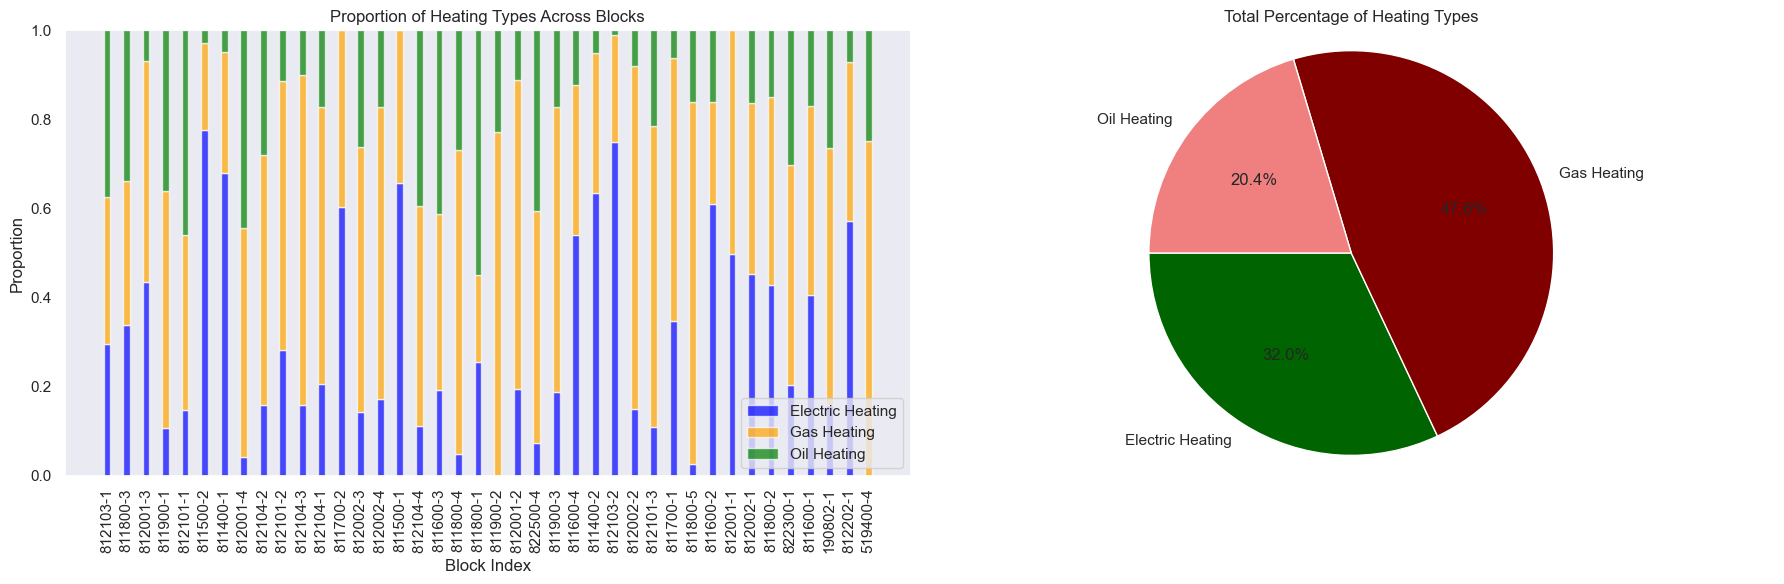

In [11]:
# Calculate proportions of heating types
total_heating_units = census_data['Electric Heating Units'] + census_data['Gas Heating Units'] + census_data['Oil Heating Units']
proportion_electric = census_data['Electric Heating Units'] / total_heating_units
proportion_gas = census_data['Gas Heating Units'] / total_heating_units
proportion_oil = census_data['Oil Heating Units'] / total_heating_units

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Stacked Bar Chart: Proportion of Heating Types Across Blocks
bar_width = 0.35
indices = np.arange(len(census_data))

ax1.bar(indices, proportion_electric, bar_width, label='Electric Heating', color='blue', alpha=0.7)
ax1.bar(indices, proportion_gas, bar_width, bottom=proportion_electric, label='Gas Heating', color='orange', alpha=0.7)
ax1.bar(indices, proportion_oil, bar_width, bottom=proportion_electric + proportion_gas, label='Oil Heating', color='green', alpha=0.7)

ax1.set_xlabel('Block Index')
ax1.set_ylabel('Proportion')
ax1.set_title('Proportion of Heating Types Across Blocks')
ax1.set_xticks(indices)
ax1.set_xticklabels(census_data['Block'], rotation=90)
ax1.legend()

# Pie Chart: Total Percentage of Heating Types
total_electric_units = census_data['Electric Heating Units'].sum()
total_gas_units = census_data['Gas Heating Units'].sum()
total_oil_units = census_data['Oil Heating Units'].sum()
total_units = total_electric_units + total_gas_units + total_oil_units
sizes = [total_electric_units, total_gas_units, total_oil_units]
labels = ['Electric Heating', 'Gas Heating', 'Oil Heating']
colors = ['darkgreen', 'maroon', 'lightcoral']


ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180)
ax2.set_title('Total Percentage of Heating Types')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()


### Average Proportion of Heating Types

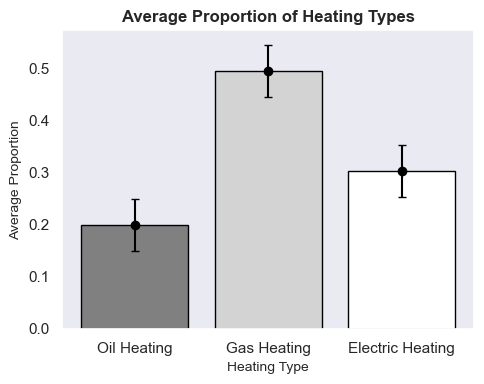

In [18]:
total_heating_units = census_data['Electric Heating Units'] + census_data['Gas Heating Units'] + census_data['Oil Heating Units']
average_proportion_electric = (census_data['Electric Heating Units'] / total_heating_units).mean()
average_proportion_gas = (census_data['Gas Heating Units'] / total_heating_units).mean()
average_proportion_oil = (census_data['Oil Heating Units'] / total_heating_units).mean()

# Create bar chart for average heating types
heating_types = ['Oil Heating', 'Gas Heating', 'Electric Heating']
average_proportions = [average_proportion_oil, average_proportion_gas, average_proportion_electric]

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(5, 4))

plt.bar(heating_types, average_proportions, color = ['grey', 'lightgrey', 'white'], alpha=1, edgecolor='black')

# Error Plotting
plt.errorbar(heating_types, average_proportions, yerr=0.05, fmt='o', color='black', ecolor='black', capsize=3)

plt.xlabel('Heating Type', fontdict={'fontsize': 10})
plt.ylabel('Average Proportion', fontdict={'fontsize': 10})
plt.title('Average Proportion of Heating Types', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(path_name + 'average_heating_types_bar_chart.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'average_heating_types_bar_chart.png', format='png', bbox_inches='tight')

plt.show()


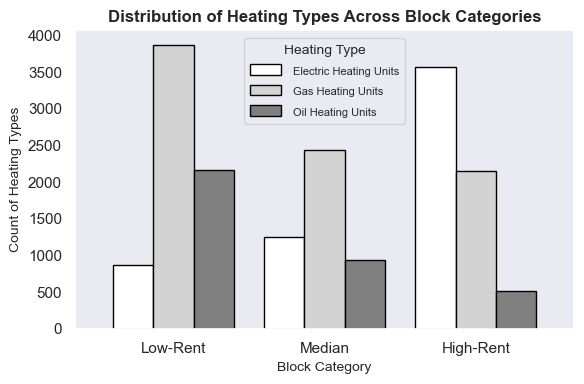

In [13]:
# Define color palette for heating types
colors = ['white', 'lightgrey', 'grey']
heating_counts_by_category = census_data.groupby('Block Category')[['Electric Heating Units', 'Gas Heating Units', 'Oil Heating Units']].sum()

# Reorder the rows of the DataFrame based on the category order
category_order = ['Low-Rent', 'Median', 'High-Rent']
heating_counts_by_category = heating_counts_by_category.reindex(category_order)

# Plotting the bar chart with specified colors
fig, ax = plt.subplots(figsize=(6, 4))
heating_counts_by_category.plot(kind='bar', ax=ax, width=0.8, color=colors, edgecolor='black')

# Adding labels and title
plt.rcParams['axes.grid'] = False

ax.set_xlabel('Block Category', fontdict={'fontsize': 10})
ax.set_ylabel('Count of Heating Types', fontdict={'fontsize': 10})
ax.set_title('Distribution of Heating Types Across Block Categories', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


# Adding legend with adjustable font size
legend = ax.legend(title='Heating Type', loc='best')
plt.setp(legend.get_title(), fontsize=10)  # Adjust the font size of the legend title
plt.setp(legend.get_texts(), fontsize=8)   # Adjust the font size of the legend labels

# Show plot
plt.tight_layout()

# Save the figure as an SVG file
plt.savefig(path_name + 'heating_types_by_category_bar_chart.svg', format='svg', bbox_inches='tight')
plt.savefig(png_path_name + 'heating_types_by_category_bar_chart.png', format='png', bbox_inches='tight')

plt.show()


### Create a new census_data file that splits house_ids into house_id with same block and new 'block category' column 

In [14]:
# Load the census data
census_data_path = 'census_data.csv'
census_data = pd.read_csv(census_data_path)

# Convert the string representation of lists in 'house_ids' to actual lists
census_data['house_ids'] = census_data['house_ids'].apply(ast.literal_eval)

# Expand the lists in 'house_ids' to multiple rows
rows = []
_ = census_data.apply(lambda row: [rows.append([row['Block'], 
                                               id, 
                                               row['Median Income'], 
                                               row['Employment Rate'], 
                                               row['Total Population'],
                                               row['Poverty'],
                                               row['Total Housing Units'],
                                               row['Renter-Occupied Units'],
                                               row['Electric Heating Units'],
                                               row['Gas Heating Units'],
                                               row['Oil Heating Units'],
                                               row['Median Year Structure Built'],
                                               row['after2014'],
                                               row['2010to2013'],
                                               row['2000to2009'],
                                               row['1990to1999'],
                                               row['1980to1989'],
                                               row['1970to1979'],
                                               row['1960to1969'],
                                               row['1950to1959'],
                                               row['1940to1949'],
                                               row['pre1939']]) for id in row.house_ids], axis=1)

# Create a new DataFrame from the expanded list
expanded_census_data = pd.DataFrame(rows, columns=['Block', 
                                                   'House ID', 
                                                   'Median Income', 
                                                   'Employment Rate', 
                                                   'Total Population',
                                                   'Poverty',
                                                   'Total Housing Units',
                                                   'Renter-Occupied Units',
                                                   'Electric Heating Units',
                                                   'Gas Heating Units',
                                                   'Oil Heating Units',
                                                   'Median Year Structure Built',
                                                   'after2014',
                                                   '2010to2013',
                                                   '2000to2009',
                                                   '1990to1999',
                                                   '1980to1989',
                                                   '1970to1979',
                                                   '1960to1969',
                                                   '1950to1959',
                                                   '1940to1949',
                                                   'pre1939'])

# Calculate percentage of Renter-Occupied Units to Total Housing Units
percentage_renter_occupied = expanded_census_data['Renter-Occupied Units'] / expanded_census_data['Total Housing Units']

# Determine percentiles for classification
low_rent_threshold = np.percentile(percentage_renter_occupied, 33)
high_rent_threshold = np.percentile(percentage_renter_occupied, 66)

# Classify blocks into categories based on renter-occupied percentages
expanded_census_data['Block Category'] = np.select(
    [percentage_renter_occupied < low_rent_threshold, 
     percentage_renter_occupied < high_rent_threshold],
    ['Low-Rent', 'Median'], 
    default='High-Rent'
)

# Add block index for each house ID within each block
expanded_census_data['Block Index'] = expanded_census_data.groupby('Block').cumcount() + 1

# Save the expanded DataFrame to a CSV file
expanded_census_data_path = 'expanded_census_data.csv'
expanded_census_data.to_csv(expanded_census_data_path, index=False)

print("Data has been processed and saved to", expanded_census_data_path)

Data has been processed and saved to expanded_census_data.csv


In [15]:
# Load the census data
census_data_path = 'census_data.csv'
census_data = pd.read_csv(census_data_path)

# Convert the string representation of lists in 'house_ids' to actual lists
census_data['house_ids'] = census_data['house_ids'].apply(ast.literal_eval)

# Expand the lists in 'house_ids' to multiple rows
rows = []
_ = census_data.apply(lambda row: [rows.append([row['Block'], id, row['Median Income'], row['Employment Rate'], row['Total Population'], row['Poverty'], row['Total Housing Units'], row['Renter-Occupied Units']]) for id in row.house_ids], axis=1)

# Create a new DataFrame from the expanded list
expanded_census_data = pd.DataFrame(rows, columns=['Block', 'House ID', 'Median Income', 'Employment Rate', 'Total Population', 'Poverty', 'Total Housing Units', 'Renter-Occupied Units'])

# Calculate percentage of Renter-Occupied Units to Total Housing Units
percentage_renter_occupied = expanded_census_data['Renter-Occupied Units'] / expanded_census_data['Total Housing Units']

# Determine percentiles for classification
low_rent_threshold = np.percentile(percentage_renter_occupied, 33)
high_rent_threshold = np.percentile(percentage_renter_occupied, 66)

# Classify blocks into categories based on renter-occupied percentages
expanded_census_data['Block Category'] = np.select(
    [percentage_renter_occupied < low_rent_threshold, 
     percentage_renter_occupied < high_rent_threshold],
    ['Low-Rent', 'Median'], 
    default='High-Rent'
)

# Select only the required columns
summary_census_data = expanded_census_data[['Block', 'Block Category', 'Median Income', 'Employment Rate', 'Total Population', 'Poverty', 'Total Housing Units']]

# Remove duplicate entries for each block, keeping the first occurrence
summary_census_data = summary_census_data.drop_duplicates(subset=['Block'])

# Save the new DataFrame to a CSV file
summary_census_data_path = 'summary_census_data.csv'
summary_census_data.to_csv(summary_census_data_path, index=False)

print("Summary data has been processed, duplicates removed, and saved to", summary_census_data_path)


Summary data has been processed, duplicates removed, and saved to summary_census_data.csv
